# TM10007 Assignment template

In [32]:
# # # Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

  Preparing metadata (setup.py) ... done


# Importing packages

In [33]:
# General packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets as ds
from statistics import mode, mean

# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

# Scoring methods
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

# Preprocessing steps
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# Feature selection
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn import decomposition

# Visualisation
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import learning_curve

# Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [34]:
## Data loading functions. Uncomment the one you want to use
from worclipo.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

The number of samples: 115
The number of columns: 494


## Creating a split in the data

A training and test set are created. The training set will be used to fit the classifier, while the test set is remained untouched until it is used for testing the trained classifier.

Split is stratified so labels are present in both sets in same proportions.

In [35]:
# Extract columns with labels
Y = data.pop('label').replace({'lipoma':0, 'liposarcoma':1}) #moeten we misschien nog ook de ID poppen?
print(f'The proportion of the labels is: {sum(Y)/len(Y)}')

# Extract the rest of the data (without the labels)
X = data
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.2, stratify=Y)

print(f'Size of training set: {X_train.shape}')
print(f'Size of test set: {X_test.shape}')

The proportion of the labels is: 0.5043478260869565
Size of training set: (92, 493)
Size of test set: (23, 493)


## Preprocessing Data

### Missing Values
Determining cells with missing values and filling these

In [36]:
# Filling missing values with correct value based on type of distribution per column

alpha = 0.05
normal_distributed_columns_count_train = 0
not_normal_distributed_columns_count_train = 0
nans_found_in_column_count_train = 0


# Checking and filling missing for train
for column in X_train:
    if X_train[column].min() != X_train[column].max():
        stat, p = shapiro(X_train[column].dropna())
        if p > alpha:
            normal_distributed_columns_count_train += 1
            if X_train[column].isna().sum() > 0:
                X_train[column].fillna(X_train[column].mean(), inplace=True)
                nans_found_in_column_count_train += 1
        else:
            not_normal_distributed_columns_count_train += 1
            if X_train[column].isna().sum() > 0:
                X_train[column].fillna(X_train[column].median(), inplace=True)
                nans_found_in_column_count_train += 1

print(f'The number of normal distributed columns in train set is : {normal_distributed_columns_count_train}')
print(f'The number of not normal distributed columns in train set is: {not_normal_distributed_columns_count_train}')
print(f'The number of columns in train set where nans were filled: {nans_found_in_column_count_train}')
print()

# Checking and filling missing for test set
normal_distributed_columns_count_test = 0
not_normal_distributed_columns_count_test = 0
nans_found_in_column_count_test = 0

for column in X_test:
    if X_test[column].min() != X_test[column].max():
        stat, p = shapiro(X_test[column].dropna())
        if p > alpha:
            normal_distributed_columns_count_test += 1
            if X_test[column].isna().sum() > 0:
                X_test[column].fillna(X_train[column].mean(), inplace=True)
                nans_found_in_column_count_test += 1
        else:
            not_normal_distributed_columns_count_test += 1
            if X_test[column].isna().sum() > 0:
                X_test[column].fillna(X_train[column].median(), inplace=True)
                nans_found_in_column_count_test += 1

print(f'The number of normal distributed columns in test set is : {normal_distributed_columns_count_test}')
print(f'The number of not normal distributed columns in test set is: {not_normal_distributed_columns_count_test}')
print(f'The number of columns in test set where nans were filled: {nans_found_in_column_count_test}')

The number of normal distributed columns in train set is : 40
The number of not normal distributed columns in train set is: 434
The number of columns in train set where nans were filled: 0

The number of normal distributed columns in test set is : 190
The number of not normal distributed columns in test set is: 277
The number of columns in test set where nans were filled: 0


### Feature Scaling
Scale features in Train set

#### Motivation of chosen scaler

In [37]:
# Calculating prescence and number of outliers
columns_many_outliers_count = 0

for column in X_train:
    Q1 = X_train[column].quantile(0.25)
    Q3 = X_train[column].quantile(0.75)
    IQR = Q3 - Q1

    outliers = X_train[(X_train[column] < (Q1 - 1.5 * IQR)) | (X_train[column] > (Q3 + 1.5 * IQR))]
    outliers_count = outliers.shape[0]

    if outliers_count > 0.05 * X_train.shape[0]:
        columns_many_outliers_count += 1

perc_columns_many_outliers = (columns_many_outliers_count / len(X_train.columns))*100
print(f"Number of columns with many outliers: {columns_many_outliers_count}/{len(X_train.columns)} = {perc_columns_many_outliers:.2f}%")

Number of columns with many outliers: 206/493 = 41.78%


#### Scaling the data

In [38]:
scaler = RobustScaler()
scaler.fit(X_train) # Fit scaler on training set

# Transform train and test set using scaler
X_train_sc = (scaler.transform(X_train))
X_test_sc = scaler.transform(X_test)

X_train_sc = pd.DataFrame(X_train_sc)
X_test_sc = pd.DataFrame(X_test_sc)

# Inspecting data

### Feature selection and extraction

In [39]:
# Determining features with zero variance and removing these
selector = VarianceThreshold(threshold=0)
vs_fit = selector.fit(X_train_sc)

X_train_zv = vs_fit.transform(X_train_sc)
X_test_zv = vs_fit.transform(X_test_sc)

# Willen we dit nou van train of test set weten?
print(f'Amount of features with zero variance: {X_train_sc.shape[1]-X_train_zv.shape[1]}')
print(f'Amount of features after removing features with zero variance: {X_train_zv.shape[1]}')

Amount of features with zero variance: 19
Amount of features after removing features with zero variance: 474


For k=1 average accuracy is 0.643 and standard deviation is 0.173
For k=2 average accuracy is 0.676 and standard deviation is 0.133
For k=3 average accuracy is 0.719 and standard deviation is 0.146
For k=4 average accuracy is 0.684 and standard deviation is 0.138
For k=5 average accuracy is 0.651 and standard deviation is 0.151
For k=6 average accuracy is 0.662 and standard deviation is 0.156
For k=7 average accuracy is 0.630 and standard deviation is 0.185
For k=8 average accuracy is 0.672 and standard deviation is 0.134
For k=9 average accuracy is 0.684 and standard deviation is 0.134
For k=10 average accuracy is 0.673 and standard deviation is 0.156


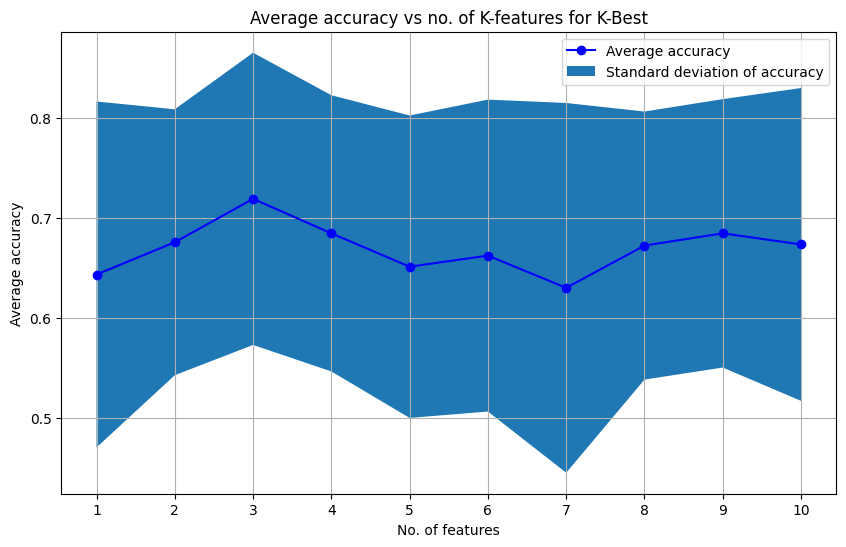

In [40]:
# Evaluating performance of selectkbest feature selection on data set

kf = StratifiedKFold(n_splits=10)
k_values = range(1, 11)
average_accuracies_k = []
std_accuracies = []

for k in k_values:

    # Select K-best features
    selector = SelectKBest(f_classif, k=k)
    X_train_select = selector.fit_transform(X_train_zv, Y_train)
    accuracies = []

    # 10-fold cross-validation
    for train_index, test_index in kf.split(X_train_select, Y_train):

        X_fold_train, X_fold_test = X_train_select[train_index], X_train_select[test_index]
        y_fold_train, y_fold_test = Y_train.iloc[train_index], Y_train.iloc[test_index]

        # Train kNN-model
        knn_model = KNeighborsClassifier()
        knn_model.fit(X_fold_train, y_fold_train)

        # Predict and evaluate accuracy
        predictions = knn_model.predict(X_fold_test)
        accuracy = accuracy_score(y_fold_test, predictions)
        accuracies.append(accuracy)

    # Calculating average accuracy for current k-number
    average_accuracy = np.mean(accuracies)
    average_accuracies_k.append(average_accuracy)

    # Calculating standard deviation accuracy for current k-number
    std_accuracy = np.std(accuracies)
    std_accuracies.append(std_accuracy)

    print(f"For k={k} average accuracy is {average_accuracy:.3f} and standard deviation is {std_accuracy:.3f}")

upper_bound = np.array(average_accuracies_k) + np.array(std_accuracies)
lower_bound = np.array(average_accuracies_k) - np.array(std_accuracies)

plt.figure(figsize=(10,6))
plt.plot(list(k_values), average_accuracies_k, marker='o', linestyle='-', color='blue', label='Average accuracy')
plt.fill_between(list(k_values), upper_bound, lower_bound, label='Standard deviation of accuracy')
plt.title('Average accuracy vs no. of K-features for K-Best')
plt.xlabel('No. of features')
plt.ylabel('Average accuracy')
plt.grid(True)
plt.xticks(list(k_values))
plt.legend()
plt.show()

n-components = 1, average accuracy = 0.501 with std dev = 0.149
n-components = 2, average accuracy = 0.481 with std dev = 0.169
n-components = 3, average accuracy = 0.566 with std dev = 0.184
n-components = 4, average accuracy = 0.623 with std dev = 0.192
n-components = 5, average accuracy = 0.569 with std dev = 0.147
n-components = 6, average accuracy = 0.569 with std dev = 0.163
n-components = 7, average accuracy = 0.513 with std dev = 0.169
n-components = 8, average accuracy = 0.579 with std dev = 0.176
n-components = 9, average accuracy = 0.599 with std dev = 0.132
n-components = 10, average accuracy = 0.588 with std dev = 0.121
Explained variance for the first element 0.9949935034473247


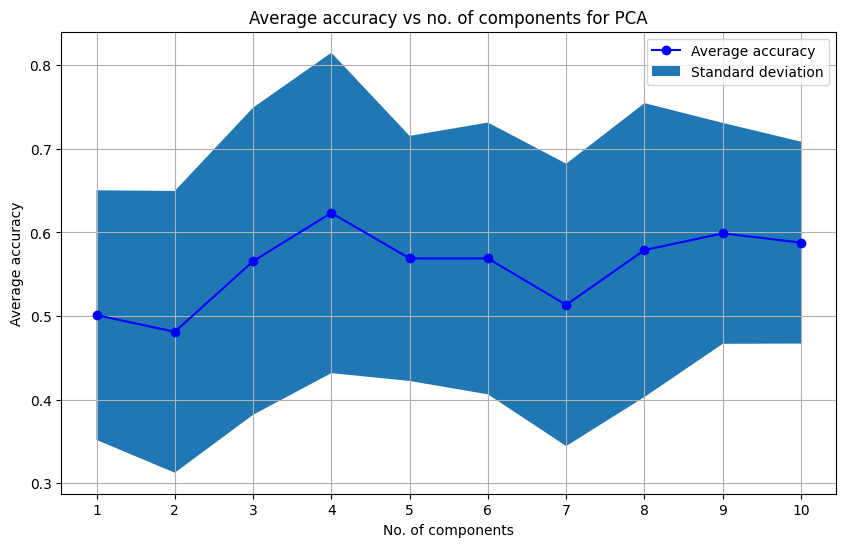

In [41]:
# Evaluating performance of PCA on dataset

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
components = range(1, 11)
average_accuracies = []
std_accuracies = []
plot_proberen = []

for n_components in components:
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_zv)
    variance = pca.explained_variance_ratio_

    if n_components == 2:
        plot_proberen.append(X_train_pca)

    accuracies = []

    for train_index, test_index in skf.split(X_train_pca, Y_train):
        X_fold_train, X_fold_test = X_train_pca[train_index], X_train_pca[test_index]
        y_fold_train, y_fold_test = Y_train.iloc[train_index], Y_train.iloc[test_index]

        knn_model = KNeighborsClassifier()
        knn_model.fit(X_fold_train, y_fold_train)

        predictions = knn_model.predict(X_fold_test)
        accuracy = accuracy_score(y_fold_test, predictions)
        accuracies.append(accuracy)

    average_accuracy = np.mean(accuracies)
    average_accuracies.append(average_accuracy)
    std_dev = np.std(accuracies)
    std_accuracies.append(std_dev)

    print(f"n-components = {n_components}, average accuracy = {average_accuracy:.3f} with std dev = {std_dev:.3f}")

print(f'Explained variance for the first element {variance[0]}')

upper_bound = np.array(average_accuracies) + np.array(std_accuracies)
lower_bound = np.array(average_accuracies) - np.array(std_accuracies)

plt.figure(figsize=(10, 6))
plt.plot(list(components), average_accuracies, marker='o', linestyle='-', color='blue', label='Average accuracy')
plt.fill_between(list(components), upper_bound, lower_bound, label='Standard deviation')
plt.title('Average accuracy vs no. of components for PCA')
plt.xlabel('No. of components')
plt.ylabel('Average accuracy')
plt.grid(True)
plt.xticks(list(components))
plt.legend()
plt.show()

(92, 474)
(23, 474)
(92, 3)
(23, 3)

Best k is k = 3 with accuracy of 0.719
Selected features for k=3 are: ['PREDICT_original_sf_area_max_2.5D', 'PREDICT_original_sf_area_std_2.5D', 'PREDICT_original_sf_volume_2.5D']



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(


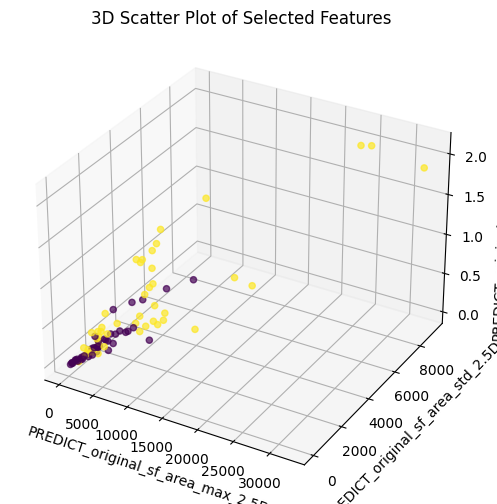

In [45]:
# Printing shape X_train_zv and X_test_zv
print(X_train_zv.shape)
print(X_test_zv.shape)

selector = VarianceThreshold()
X_train_zv_fit = selector.fit_transform(X_train)
X_train_zv_fit = pd.DataFrame(X_train_zv_fit, columns=X_train.columns[selector.get_support()])
X_test_zv = pd.DataFrame(X_test_zv)

selected_feature_names = []

# Determining best k and associated features
best_k_index = np.argmax(average_accuracies_k)
best_k = k_values[best_k_index]
best_accuracy = average_accuracies_k[best_k_index]

selector = SelectKBest(f_classif, k=best_k)
X_train_select = selector.fit_transform(X_train_zv_fit, Y_train)
selected_features = X_train_zv_fit.columns[selector.get_support()]
selected_feature_names = selected_features.tolist()

selector_fs = SelectKBest(f_classif, k=best_k) #dit veranderen ahv plot
fitted_kbest = selector_fs.fit(X_train_zv_fit, Y_train)

X_train_fs = fitted_kbest.transform(X_train_zv_fit)
X_test_fs = fitted_kbest.transform(X_test_zv)

# Printing shape X_train_fs and X_test_fs after feature selection
print(X_train_fs.shape)
print(X_test_fs.shape)
print()

print(f"Best k is k = {best_k} with accuracy of {best_accuracy:.3f}")
print(f"Selected features for k={best_k} are: {selected_feature_names}")
print()

if len(selected_feature_names) ==2:
  sns.scatterplot(x=selected_feature_names[0], y=selected_feature_names[1], hue = Y, data = data)
if len(selected_feature_names) == 3:
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Extract the features for plotting
    feature1 = X_train_fs[:, 0]
    feature2 = X_train_fs[:, 1]
    feature3 = X_train_fs[:, 2]

    # Scatter plot
    scatter = ax.scatter(feature1, feature2, feature3, c=Y_train, cmap='viridis', alpha=0.7)

    # Labeling
    ax.set_xlabel(selected_feature_names[0])
    ax.set_ylabel(selected_feature_names[1])
    ax.set_zlabel(selected_feature_names[2])

    plt.title('3D Scatter Plot of Selected Features')
    plt.show()

else:
  print(f"Visualization of a 2D scatterplot is not possible for k = {best_k}")


# Classifiers

In [ ]:
# Define outer cross validation
outer_cv = KFold(n_splits=5, shuffle=True)

### KNN

In [ ]:
results = {
    'best_estimators': [],
    'training_scores': [],
    'test_scores': [],
    'params': []
}

max_n_neighbors = len(X_train_fs) // outer_cv.get_n_splits(X_train_fs) - 1
print("Max number of neighbors:", max_n_neighbors)

# Outer cross-validation loop
for train_index, test_index in outer_cv.split(X_train_fs, Y_train):
    X_train_outer, X_test_outer = X_train_fs[train_index], X_train_fs[test_index]
    Y_train_outer, Y_test_outer = Y_train[train_index], Y_train[test_index]

    # Define the inner cross-validation strategy
    inner_cv = KFold(n_splits=3, shuffle=True)

    # Define the parameter grid
    param_grid_KNN = {
        'n_neighbors': list(range(1, max_n_neighbors, 2)),
        'weights': ['uniform', 'distance'],
        'p': [1, 2]  # p=1 for Manhattan distance, p=2 for Euclidean distance
    }

    # Initialize the grid search object
    grid_search_KNN = GridSearchCV(KNeighborsClassifier(), param_grid_KNN, cv=inner_cv, scoring='roc_auc')

    # Fit the grid search object to the training data
    grid_search_KNN.fit(X_train_outer, Y_train_outer)

    # Get the best estimator from the inner loop
    best_estimator = grid_search_KNN.best_estimator_
    best_params = best_estimator.get_params()
    print('Best estimator:', best_estimator)

    # Store the best estimator
    results['best_estimators'].append(best_estimator)
    results['params'].append(best_params)

    # Get train and test score
    pred_proba_KNN_train_loop = best_estimator.predict_proba(X_train_outer)[:,1]
    results['training_scores'].append(roc_auc_score(Y_train_outer, pred_proba_KNN_train_loop))

    pred_proba_KNN_test_loop = best_estimator.predict_proba(X_test_outer)[:,1]
    results['test_scores'].append(roc_auc_score(Y_test_outer, pred_proba_KNN_test_loop))

# Find optimal hyperparameters using median or mode (for boolean)
n_neighbors_list = [params['n_neighbors'] for params in results['params']]
weights_list = [params['weights'] for params in results['params']]
p_list = [params['p'] for params in results['params']]

# Calculate median or mode
n_neighbors = int(np.median(n_neighbors_list))
weights = mode(weights_list)
p = mode(p_list)
best_params = [n_neighbors, weights, p]

final_KNN_model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, p=p)

# Fit the final model to the entire training data
final_KNN_model.fit(X_train_fs, Y_train)

# See how well final model works on entire train set:
pred_KNN_train = final_KNN_model.predict(X_train_fs)
pred_proba_KNN_train = final_KNN_model.predict_proba(X_train_fs)[:,1]

roc_auc_KNN_train = roc_auc_score(Y_train, pred_proba_KNN_train)
print('ROC AUC train=', roc_auc_KNN_train)
accuracy_KNN_train = accuracy_score(Y_train, pred_KNN_train)
print('Accuracy train=', accuracy_KNN_train)

# See how well model works on entire test set:
pred_KNN_test = final_KNN_model.predict(X_test_fs)
pred_proba_KNN_test = final_KNN_model.predict_proba(X_test_fs)[:,1]

roc_auc_KNN_test = roc_auc_score(Y_test, pred_proba_KNN_test)
print('ROC AUC test=', roc_auc_KNN_test)
accuracy_KNN_test = accuracy_score(Y_test, pred_KNN_test)
print('Accuracy test=', accuracy_KNN_test)

results_KNN = {
    'Best hyperparameters': best_params,
    'Avarage train score': mean(results['training_scores']),
    'Avarage test score': mean(results['test_scores'])
}

# Printing the dictionary in a clear format
print("Results for K Nearest Neighbor Model:")
print("---------------------------------")
for key, value in results_KNN.items():
    print(f"{key}: {value}")

Max number of neighbors: 17
Best estimator: KNeighborsClassifier(n_neighbors=9, p=1)
Best estimator: KNeighborsClassifier(n_neighbors=13, p=1)
Best estimator: KNeighborsClassifier(p=1, weights='distance')
Best estimator: KNeighborsClassifier(n_neighbors=11, p=1)
Best estimator: KNeighborsClassifier(n_neighbors=11, p=1, weights='distance')
ROC AUC train= 0.8674385633270322
Accuracy train= 0.8043478260869565
ROC AUC test= 0.5
Accuracy test= 0.4782608695652174
Results for K Nearest Neighbor Model:
---------------------------------
Best hyperparameters: [11, 'uniform', 1]
Avarage train score: 0.9230372697477961
Avarage test score: 0.784017094017094


### Random forest

In [ ]:
# Initialize lists to store results
results = {
    'best_estimators': [],
    'training_scores': [],
    'test_scores': [],
    'params': []
}

# Outer cross-validation loop
for train_index, test_index in outer_cv.split(X_train_fs, Y_train):
    X_train_outer, X_test_outer = X_train_fs[train_index], X_train_fs[test_index]
    Y_train_outer, Y_test_outer = Y_train[train_index], Y_train[test_index]

    # Define the inner cross-validation strategy
    inner_cv = KFold(n_splits=3, shuffle=True)

    # Define the parameter grid
    param_grid_RF = {
        'n_estimators': list(range(1, 100, 1)),
        'bootstrap': [True, False],
        'min_samples_leaf': list(range(1, 9, 2))
    }

    # Initialize the grid search object
    grid_search_RF = GridSearchCV(RandomForestClassifier(), param_grid_RF, cv=inner_cv, scoring='roc_auc')

    # Fit the grid search object to the training data
    grid_search_RF.fit(X_train_outer, Y_train_outer)

    # Get the best estimator from the inner loop
    best_estimator = grid_search_RF.best_estimator_
    best_params = best_estimator.get_params()
    print('Best estimator:', best_estimator)

    # Store the best estimator
    results['best_estimators'].append(best_estimator)
    results['params'].append(best_params)

    # Get train and test score
    pred_proba_RF_train_loop = best_estimator.predict_proba(X_train_outer)[:,1]
    results['training_scores'].append(roc_auc_score(Y_train_outer, pred_proba_RF_train_loop))

    pred_proba_RF_test_loop = best_estimator.predict_proba(X_test_outer)[:,1]
    results['test_scores'].append(roc_auc_score(Y_test_outer, pred_proba_RF_test_loop))

# Find optimal hyperparameters using median or mode (for boolean)
n_estimators_list = [params['n_estimators'] for params in results['params']]
bootstrap_list = [params['bootstrap'] for params in results['params']]
min_samples_leaf_list = [params['min_samples_leaf'] for params in results['params']]

# Calculate median or mode
n_estimators = int(np.median(n_estimators_list))
bootstrap = mode(bootstrap_list)
min_samples_leaf = int(np.median(min_samples_leaf_list))
best_params = [n_estimators, bootstrap, min_samples_leaf]

final_RF_model = RandomForestClassifier(n_estimators=n_estimators, bootstrap=bootstrap, min_samples_leaf=min_samples_leaf)

# Fit the final model to the entire training data
final_RF_model.fit(X_train_fs, Y_train)

# See how well final model works on entire train set:
pred_RF_train = final_RF_model.predict(X_train_fs)
pred_proba_RF_train = final_RF_model.predict_proba(X_train_fs)[:,1]

roc_auc_RF_train = roc_auc_score(Y_train, pred_proba_RF_train)
print('ROC AUC train=', roc_auc_RF_train)
accuracy_RF_train = accuracy_score(Y_train, pred_RF_train)
print('Accuracy train=', accuracy_RF_train)

# See how well model works on entire test set:
pred_RF_test = final_RF_model.predict(X_test_fs)
pred_proba_RF_test = final_RF_model.predict_proba(X_test_fs)[:,1]

roc_auc_RF_test = roc_auc_score(Y_test, pred_proba_RF_test)
print('ROC AUC test=', roc_auc_RF_test)
accuracy_RF_test = accuracy_score(Y_test, pred_RF_test)
print('Accuracy test=', accuracy_RF_test)

results_RF = {
    'Best hyperparameters': best_params,
    'Avarage train score': mean(results['training_scores']),
    'Avarage test score': mean(results['test_scores'])
}

# Printing the dictionary in a clear format
print("Results for Random Forest Model:")
print("---------------------------------")
for key, value in results_RF.items():
    print(f"{key}: {value}")

### Support Vector Machine

In [ ]:
results = {
    'best_estimators': [],
    'training_scores': [],
    'test_scores': [],
    'params': []
}

# Outer cross-validation loop
for train_index, test_index in outer_cv.split(X_train_fs, Y_train):
    X_train_outer, X_test_outer = X_train_fs[train_index], X_train_fs[test_index]
    Y_train_outer, Y_test_outer = Y_train[train_index], Y_train[test_index]

    # Define the inner cross-validation strategy
    inner_cv = KFold(n_splits=3, shuffle=True)

    # Define the parameter grid
    param_grid_SVM = {
        'C': [0.001, 0.01, 0.1, 1, 10],  # Regularization parameter
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],  # Kernel coefficient
        'kernel': ['rbf', 'linear', 'poly'] # Kernel type
    }

    # Initialize the grid search object
    grid_search_SVM = GridSearchCV(svm.SVC(probability=True), param_grid_SVM, cv=inner_cv, scoring='roc_auc')

    # Fit the grid search object to the training data
    grid_search_SVM.fit(X_train_outer, Y_train_outer)

    # Get the best estimator from the inner loop
    best_estimator = grid_search_SVM.best_estimator_
    best_params = best_estimator.get_params()
    print('Best estimator:', best_estimator)

    # Store the best estimator
    results['best_estimators'].append(best_estimator)
    results['params'].append(best_params)

    # Get train and test score
    pred_proba_SVM_train_loop = best_estimator.predict_proba(X_train_outer)[:,1]
    results['training_scores'].append(roc_auc_score(Y_train_outer, pred_proba_SVM_train_loop))

    pred_proba_SVM_test_loop = best_estimator.predict_proba(X_test_outer)[:,1]
    results['test_scores'].append(roc_auc_score(Y_test_outer, pred_proba_SVM_test_loop))

# Find optimal hyperparameters using median or mode (for boolean)
C_list = [params['C'] for params in results['params']]
gamma_list = [params['gamma'] for params in results['params']]
kernel_list = [params['kernel'] for params in results['params']]

# Calculate median or mode
C = mode(C_list)
gamma = mode(gamma_list)
kernel = mode(kernel_list)
best_params = [C, gamma, kernel]

final_SVM_model = svm.SVC(probability=True, C=C, gamma=gamma, kernel=kernel)
print('Final SVM model:', final_SVM_model)

# Fit the final model to the entire training data
final_SVM_model.fit(X_train_fs, Y_train)

# See how well final model works on entire train set:
pred_SVM_train = final_SVM_model.predict(X_train_fs)
pred_proba_SVM_train = final_SVM_model.predict_proba(X_train_fs)[:,1]

roc_auc_SVM_train = roc_auc_score(Y_train, pred_proba_SVM_train)
print('ROC AUC train=', roc_auc_SVM_train)
accuracy_SVM_train = accuracy_score(Y_train, pred_SVM_train)
print('Accuracy train=', accuracy_SVM_train)

# See how well model works on entire test set:
pred_SVM_test = final_SVM_model.predict(X_test_fs)
pred_proba_SVM_test = final_SVM_model.predict_proba(X_test_fs)[:,1]

roc_auc_SVM_test = roc_auc_score(Y_test, pred_proba_SVM_test)
print('ROC AUC test=', roc_auc_SVM_test)
accuracy_SVM_test = accuracy_score(Y_test, pred_SVM_test)
print('Accuracy test=', accuracy_SVM_test)

results_SVM = {
    'Best hyperparameters': best_params,
    'Avarage train score': mean(results['training_scores']),
    'Avarage test score': mean(results['test_scores'])
}

# Printing the dictionary in a clear format
print("Results for Support Vector Machine:")
print("---------------------------------")
for key, value in results_SVM.items():
    print(f"{key}: {value}")

# Visualisatie

In [ ]:
def plot_learning_curve(estimator, title, X, Y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    '''plotting learning curve'''

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, Y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, scoring = 'roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="lower center")

    return plt

## Learning curves

In [ ]:
fig = plt.figure(figsize=(15,4))

# knn
ax = fig.add_subplot(1, 3, 1)
plot_learning_curve(final_KNN_model, 'KNN classifier', X_train_fs, Y_train, ax, ylim=(0.3, 1.03), cv=outer_cv)

# RF
ax = fig.add_subplot(1, 3, 2)
plot_learning_curve(final_RF_model, 'RF classifier', X_train_fs, Y_train, ax, ylim=(0.3, 1.03), cv=outer_cv)

# CVM
ax = fig.add_subplot(1, 3, 3)
plot_learning_curve(final_SVM_model, 'SVM classifier', X_train_fs, Y_train, ax, ylim=(0.3, 1.03), cv=outer_cv)

## Receiver Operating Curve

In [ ]:
plt.figure()
lw = 2
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Curve')

# KNN
fpr_KNN, tpr_KNN, _ = roc_curve(Y_test, pred_proba_KNN_test)
roc_auc_KNN = auc(fpr_KNN, tpr_KNN)
plt.plot(fpr_KNN, tpr_KNN, lw=lw, label='KNN (AUC = %0.2f)' % roc_auc_KNN)

# RF
fpr_RF, tpr_RF, _ = roc_curve(Y_test, pred_proba_RF_test)
roc_auc_RF = auc(fpr_RF, tpr_RF)
plt.plot(fpr_RF, tpr_RF, lw=lw, label='RF (AUC = %0.2f)' % roc_auc_RF)

# SVM
fpr_SVM, tpr_SVM, _ = roc_curve(Y_test, pred_proba_SVM_test)
roc_auc_SVM = auc(fpr_SVM, tpr_SVM)
plt.plot(fpr_SVM, tpr_SVM, lw=lw, label='SVM (AUC = %0.2f)' % roc_auc_SVM)

plt.legend(loc="lower right")
plt.show()